## Generalization 

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append(3*'../')

import os
import glob
from pathlib import Path
from omegaconf import DictConfig
import yaml
import pickle
from collections import defaultdict


import torch
import lightning as L

from rl4co.envs import TSPEnv, CVRPEnv
from rl4co.tasks.rl4co import RL4COLitModule
from rl4co.utils.lightning import load_model_from_checkpoint, clean_hydra_config
from rl4co.tasks.eval import evaluate_policy


/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


## Load solver solutions

In [2]:
device = torch.device("cuda:5")

exp_name = 'tsp20'
env = TSPEnv()


In [3]:
solver_path = Path("../solver/tsp")
solver_files = glob.glob(str(solver_path / "*tsp*.pkl"), recursive=True)


# Concorde
def load_solver_file(num_nodes):
    # load pickle of first solver file
    file_ = solver_path / f"tsp_{num_nodes}.pkl"
    with open(file_, 'rb') as f:
        costs = pickle.load(f)
    print("Concorde time for {} nodes: {:.2f}s".format(num_nodes, costs[0]))
    print("Average cost: {:.2f}".format(sum(costs[1])/len(costs[1])))
    return costs[1]

## Loading datasets

In [4]:
# Get all files that contain "generalization*.npz" under data/tsp
data_dir = Path("../data/tsp")
files = glob.glob(str(data_dir / "*generalization*.npz"), recursive=True)
# files =  sorted(files)
# print(files)

num_nodes = [10, 20, 50, 75, 100, 125, 150, 200, 500, 1000]


datasets = []
for num_nodes_ in num_nodes:
    for file in files:
        if "tsp{}_".format(num_nodes_) in file:
            dataset = env.dataset(filename=file, phase='test')
            solver_costs = load_solver_file(num_nodes_)
            datasets.append({'num_nodes': num_nodes_, 'file': file, 
                             'dataset': dataset, 'solver_costs': solver_costs})

Concorde time for 10 nodes: 67.52s
Average cost: 2.86
Concorde time for 20 nodes: 1132.89s
Average cost: 3.84
Concorde time for 50 nodes: 1904.55s
Average cost: 5.70
Concorde time for 75 nodes: 232.56s
Average cost: 6.81
Concorde time for 100 nodes: 4107.35s
Average cost: 7.76
Concorde time for 125 nodes: 511.61s
Average cost: 8.59
Concorde time for 150 nodes: 791.64s
Average cost: 9.37
Concorde time for 200 nodes: 1339.49s
Average cost: 10.70
Concorde time for 500 nodes: 14330.72s
Average cost: 16.54
Concorde time for 1000 nodes: 136436.25s
Average cost: 23.13


## Loading model from checkpoint

In [5]:
def load_policy(exp_name, epoch, model_name):

    main_dir = Path('../../../saved_checkpoints/')

    main_dir = main_dir / exp_name / model_name

    cfg_path = main_dir / 'config.yaml'
    ckpt_path = main_dir / 'epoch_{}.ckpt'.format(epoch)

    lit_module = load_model_from_checkpoint(cfg_path, ckpt_path, phase='test')

    policy = lit_module.model.policy.to(device)
    policy.eval()
    return policy

In [6]:
def optimality_gap(bk_sol, opt_sol):
    return ((bk_sol - opt_sol) / bk_sol).mean().item() * 100

In [7]:
def get_generalization_stats(policy):
    stats = defaultdict(list)

    for dataset in datasets:
        print("====================")
        print("Evaluating dataset: {}".format(dataset['file']))
        stats['num_nodes'].append(dataset['num_nodes'])
        stats['file'].append(dataset['file'])
        out_dict = evaluate_policy(env, policy, dataset['dataset'], method='greedy', max_batch_size=128)

        model_costs = -out_dict['rewards']
        solver_costs = torch.Tensor(dataset['solver_costs'][:1000]) # by default, we only evaluate on 1000 samples

        stats['model_cost_mean'].append(model_costs.mean())
        stats['solver_cost_mean'].append(solver_costs.mean())
        gap = optimality_gap(model_costs, solver_costs)
        stats['optimality_gap'].append(gap)

        print("Optimality gap: {:.2f}%".format(gap))

    return stats

In [8]:
# # Pointer Net
# model_name = "ptrnet-tsp50"
# epoch = "099"
# model = load_policy(exp_name, epoch, model_name)
# ptrnet_stats = get_generalization_stats(model)

In [9]:
# AM Critic
model_name = f"am-critic-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
am_critic_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1368833, 'trainable': 1368833, 'non_trainable': 0}}


Evaluating dataset: ../data/tsp/tsp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -2.8681
Time: 0.2073s
Optimality gap: 0.15%
Evaluating dataset: ../data/tsp/tsp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -3.8707
Time: 0.1982s
Optimality gap: 0.65%
Evaluating dataset: ../data/tsp/tsp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -5.9709
Time: 0.4569s
Optimality gap: 4.69%
Evaluating dataset: ../data/tsp/tsp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -7.5045
Time: 0.6646s
Optimality gap: 9.16%
Evaluating dataset: ../data/tsp/tsp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -8.9131
Time: 0.8915s
Optimality gap: 12.95%
Evaluating dataset: ../data/tsp/tsp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -10.2602
Time: 1.1046s
Optimality gap: 16.18%
Evaluating dataset: ../data/tsp/tsp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.5128
Time: 1.3211s
Optimality gap: 18.55%
Evaluating dataset: ../data/tsp/tsp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -13.7785
Time: 1.7583s
Optimality gap: 22.29%
Evaluating dataset: ../data/tsp/tsp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -24.6970
Time: 5.7915s
Optimality gap: 33.01%
Evaluating dataset: ../data/tsp/tsp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -38.5294
Time: 17.2470s
Optimality gap: 39.96%


In [10]:
# AM
model_name = f"am-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
am_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 708608, 'trainable': 708608, 'non_trainable': 0}}


Evaluating dataset: ../data/tsp/tsp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -2.8657
Time: 0.1155s
Optimality gap: 0.07%
Evaluating dataset: ../data/tsp/tsp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -3.8519
Time: 0.1992s
Optimality gap: 0.18%
Evaluating dataset: ../data/tsp/tsp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -5.9097
Time: 0.4559s
Optimality gap: 3.70%
Evaluating dataset: ../data/tsp/tsp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -7.4661
Time: 0.6621s
Optimality gap: 8.68%
Evaluating dataset: ../data/tsp/tsp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -8.9376
Time: 0.8823s
Optimality gap: 13.17%
Evaluating dataset: ../data/tsp/tsp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -10.3212
Time: 1.1056s
Optimality gap: 16.66%
Evaluating dataset: ../data/tsp/tsp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.6000
Time: 1.3282s
Optimality gap: 19.16%
Evaluating dataset: ../data/tsp/tsp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -13.9027
Time: 1.7772s
Optimality gap: 22.99%
Evaluating dataset: ../data/tsp/tsp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -24.8477
Time: 5.8357s
Optimality gap: 33.41%
Evaluating dataset: ../data/tsp/tsp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -38.7495
Time: 17.0420s
Optimality gap: 40.30%


In [11]:
# POMO
model_name = f"pomo-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
pomo_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1301888, 'trainable': 1301888, 'non_trainable': 0}}


Evaluating dataset: ../data/tsp/tsp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -2.8657
Time: 0.1424s
Optimality gap: 0.07%
Evaluating dataset: ../data/tsp/tsp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -3.8522
Time: 0.2175s
Optimality gap: 0.18%
Evaluating dataset: ../data/tsp/tsp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -5.9854
Time: 0.4746s
Optimality gap: 4.81%
Evaluating dataset: ../data/tsp/tsp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -7.8970
Time: 0.6983s
Optimality gap: 13.41%
Evaluating dataset: ../data/tsp/tsp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -9.6214
Time: 0.9165s
Optimality gap: 19.16%
Evaluating dataset: ../data/tsp/tsp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.1764
Time: 1.1428s
Optimality gap: 22.90%
Evaluating dataset: ../data/tsp/tsp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -12.5479
Time: 1.3783s
Optimality gap: 25.16%
Evaluating dataset: ../data/tsp/tsp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -14.8703
Time: 1.8326s
Optimality gap: 27.92%
Evaluating dataset: ../data/tsp/tsp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -25.2353
Time: 6.1271s
Optimality gap: 34.41%
Evaluating dataset: ../data/tsp/tsp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -36.9771
Time: 18.0581s
Optimality gap: 37.43%


In [12]:
# SymNCO
model_name = f"symnco-{exp_name}"
epoch = "099"
model = load_policy(exp_name, epoch, model_name)
symnco_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1334912, 'trainable': 1334912, 'non_trainable': 0}}


Evaluating dataset: ../data/tsp/tsp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -2.8646
Time: 0.1365s
Optimality gap: 0.04%
Evaluating dataset: ../data/tsp/tsp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -3.8469
Time: 0.2260s
Optimality gap: 0.05%
Evaluating dataset: ../data/tsp/tsp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -5.8487
Time: 0.4890s
Optimality gap: 2.72%
Evaluating dataset: ../data/tsp/tsp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -7.4053
Time: 0.7038s
Optimality gap: 7.93%
Evaluating dataset: ../data/tsp/tsp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -8.8499
Time: 0.9269s
Optimality gap: 12.31%
Evaluating dataset: ../data/tsp/tsp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -10.2038
Time: 1.1445s
Optimality gap: 15.70%
Evaluating dataset: ../data/tsp/tsp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.4524
Time: 1.3847s
Optimality gap: 18.12%
Evaluating dataset: ../data/tsp/tsp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -13.6708
Time: 1.8413s
Optimality gap: 21.68%
Evaluating dataset: ../data/tsp/tsp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -23.9845
Time: 6.1269s
Optimality gap: 31.01%
Evaluating dataset: ../data/tsp/tsp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -36.8153
Time: 18.1154s
Optimality gap: 37.17%


In [13]:
# AM-xl
model_name = f"am-{exp_name}-sm-xl"
epoch = "499"
model = load_policy(exp_name, epoch, model_name)
am_xl_stats = get_generalization_stats(model)

Unused kwargs: {'params': {'total': 1301888, 'trainable': 1301888, 'non_trainable': 0}}


Evaluating dataset: ../data/tsp/tsp10_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -2.8650
Time: 0.1351s
Optimality gap: 0.05%
Evaluating dataset: ../data/tsp/tsp20_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -3.8479
Time: 0.2232s
Optimality gap: 0.08%
Evaluating dataset: ../data/tsp/tsp50_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -5.8577
Time: 0.4835s
Optimality gap: 2.87%
Evaluating dataset: ../data/tsp/tsp75_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -7.3887
Time: 0.7018s
Optimality gap: 7.73%
Evaluating dataset: ../data/tsp/tsp100_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -8.8401
Time: 0.9327s
Optimality gap: 12.21%
Evaluating dataset: ../data/tsp/tsp125_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -10.1971
Time: 1.1460s
Optimality gap: 15.63%
Evaluating dataset: ../data/tsp/tsp150_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -11.4516
Time: 1.3869s
Optimality gap: 18.11%
Evaluating dataset: ../data/tsp/tsp200_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -13.6844
Time: 2.0037s
Optimality gap: 21.76%
Evaluating dataset: ../data/tsp/tsp500_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -24.1265
Time: 6.1557s
Optimality gap: 31.42%
Evaluating dataset: ../data/tsp/tsp1000_test_generalization_seed1234.npz
Effective batch size: 128 (ratio: 1)
Using automatic batch size: 128


Running greedy:   0%|          | 0/8 [00:00<?, ?it/s]

Mean reward for greedy: -37.1931
Time: 18.1232s
Optimality gap: 37.80%


In [14]:
experiments = { 
    # 'ptrnet': ptrnet_stats,
    'am-critic': am_critic_stats,
    'am': am_stats,
    'pomo': pomo_stats, 
    'symnco': symnco_stats,
    'am-xl': am_xl_stats,
}

colors = {
    # 'ptrnet': 'tab:brown',
    'am-critic': 'tab:red',
    'am': 'tab:blue',
    'pomo': 'tab:orange',
    'symnco': 'tab:green',
    'am-xl': 'tab:purple',
}

labels = {
    # 'ptrnet': 'PointerNet',
    'am-critic': 'AM-critic',
    'am': 'AM',
    'pomo': 'POMO',
    'symnco': 'SymNCO',
    'am-xl': 'AM-XL',
}

In [15]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({'text.usetex': True,
                    'font.family': 'serif',
                    # 'font.size': 16,
})

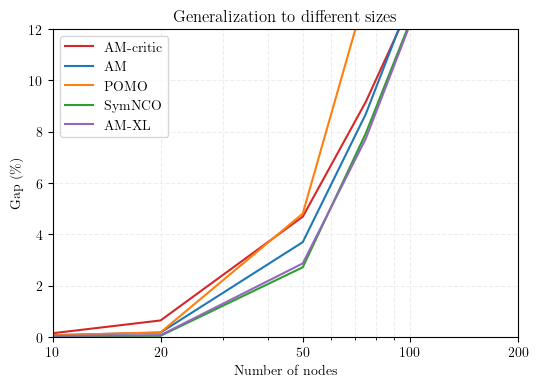

In [16]:

fig, ax = plt.subplots(figsize=(6,4))

data_generalization = defaultdict(list)

for experiment in experiments:
    # add data to save and plot
    stats = experiments[experiment]
    data_generalization[experiment] = stats

    ax.plot(stats['num_nodes'], stats['optimality_gap'], label=labels[experiment], color=colors[experiment])

# log scale
ax.set_xscale('log')
# ax.set_yscale('log')

# cut plot at 10 nodes
# ax.set_xlim([10, 1000])
ax.set_xlim([10, 200])

# replace x-axis ticks
# ax.set_xticks([10, 20, 50, 100, 200, 500, 1000])
ax.set_xticks([10, 20, 50, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# Set plot title
ax.set_title('Generalization to different sizes')

# Set x-axis label
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Gap (\%)')

ax.set_ylim([0, 12])
ax.set_ylim([0, None])

# Training size: draw vertical line at num_nodes = stats['num_nodes'][-1]
# ax.axvline(x=stats['num_nodes'][-1])#, color='tab:red', linestyle='--', linewidth=1)

# Set grid on with dashed lines for log scale
ax.grid(True, which="both", ls="--", color='0.93')

# legend
ax.legend(loc='upper left')

# Save plot data
save_folder = Path('plots/')
save_folder.mkdir(parents=True, exist_ok=True)
plt.savefig(save_folder / f'{exp_name}.pdf', bbox_inches='tight')

# Save data with pickle
with open(save_folder / f'{exp_name}_data.pkl', 'wb') as f:
    pickle.dump(data_generalization, f)